# Using `pyamgx` to accelerate the finite volume code `FiPy`

This notebook demonstrates how `pyamgx` can be used to speed up the [`FiPy`](https://www.ctcms.nist.gov/fipy/) finite volume code. The speed-up results from the solution of sparse linear systems being done on the GPU rather than the CPU.

In [1]:
%matplotlib inline

In [2]:
import time

## Background

Solving PDEs by the finite volume method requires the solution of sparse linear systems. [Currently](https://www.ctcms.nist.gov/fipy/documentation/SOLVERS.html), `FiPy` can use solvers from the following packages:

1. [PySparse](http://pysparse.sourceforge.net)
2. [SciPy](http://www.scipy.org/)
3. [Trillinos](http://trilinos.sandia.gov) via the PyTrillinos package
4. [PyAMG](http://code.google.com/p/pyamg/) - not to be confused with `pyamgx`

Solvers from these packages are encapsulated in FiPy's solver classes such as `fipy.solvers.scipy.linearCGSSolver.LinearCGSSolver` (SciPy Conjugate Gradient solver) and `fipy.solvers.pyAMG.linearGMRESSolver.LinearGMRESSolver` (PyAMG GMRES solver).
All of FiPy's solver classes provide a common interface and inherit from a `Solver` base class.

Using `pyamgx`, It's relatively simple to write a `PyAMGXSolver` class that will serve as an interface to the solvers provided by the [AMGX](https://github.com/NVIDIA/AMGX) library:

In [3]:
from fipy.solvers.solver import Solver
from fipy.matrices.scipyMatrix import _ScipyMeshMatrix
from fipy.tools import numerix

import numpy
from scipy.sparse import csr_matrix
import pyamgx
import os

class PyAMGXSolver(Solver):
    """
    The PyAMGXSolver class.
    """

    def __init__(self, config_dict, *args, **kwargs):
        """
        Parameters
        ----------
        config_dict : dict
            Dictionary specifying AMGX configuration options
        """
        self.config_dict = config_dict
        self.cfg = pyamgx.Config().create_from_dict(self.config_dict)
        self.resources = pyamgx.Resources().create_simple(self.cfg)
        self.x_gpu = pyamgx.Vector().create(self.resources)
        self.b_gpu = pyamgx.Vector().create(self.resources)
        self.A_gpu = pyamgx.Matrix().create(self.resources)
        self.solver = pyamgx.Solver().create(self.resources, self.cfg)

    @property
    def _matrixClass(self):
        return _ScipyMeshMatrix

    def _storeMatrix(self, var, matrix, RHSvector):
        self.var = var
        self.matrix = matrix
        self.RHSvector = RHSvector

        self.A_gpu.upload_CSR(self.matrix.matrix)
        self.solver.setup(self.A_gpu)

    def _solve_(self, L, x, b):
        # transfer data from CPU to GPU
        self.x_gpu.upload(x)
        self.b_gpu.upload(b)

        # solve system on GPU
        self.solver.solve(self.b_gpu, self.x_gpu)

        # download values from GPU to CPU
        self.x_gpu.download(x)

    def _solve(self):
        self._solve_(self.matrix, self.var.ravel(), numerix.array(self.RHSvector))
            
    def _canSolveAsymmetric(self):
        return False

    def destroy(self):
        self.A_gpu.destroy()
        self.b_gpu.destroy()
        self.x_gpu.destroy()
        self.solver.destroy()
        self.resources.destroy()
        self.cfg.destroy()

The examples below compare the performance of `PyAMGXSolver` with other FiPy solvers.

## Example 1: Steady-state diffusion

In this example, `FiPy` is used to solve the two-dimensional steady-state diffusion equation ($\nabla^2 \phi =0 $). This example is in turn, based on the FiPy example described [here](https://www.ctcms.nist.gov/fipy/examples/diffusion/generated/examples.diffusion.mesh20x20.html).

In [4]:
# Set up the initial values and boundary conditions for the solution variable `phi`:
from fipy import *
nx = 1000
ny = nx
dx = 1.
dy = dx
L = dx * nx
mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

phi = CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = 0.5) # `value` specifies the initial values

valueTopLeft = 0
valueBottomRight = 1

X, Y = mesh.faceCenters
facesTopLeft = ((mesh.facesLeft & (Y > L / 2))
                 | (mesh.facesTop & (X < L / 2)))
facesBottomRight = ((mesh.facesRight & (Y < L / 2))
                     | (mesh.facesBottom & (X > L / 2)))

phi.constrain(valueTopLeft, facesTopLeft)
phi.constrain(valueBottomRight, facesBottomRight)

### Default FiPy solver:

Value of phi at (x, y) = (0.5, 0.5): [0.5]
Time for solve: 7.631793975830078 seconds.


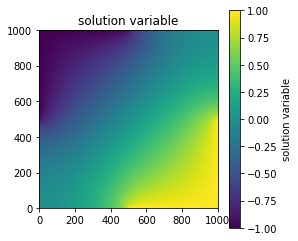

In [5]:
# Solve the equation using the default FiPy solver
t1 = time.time()
DiffusionTerm().solve(var=phi)
t2 = time.time()

viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='viridis')

print("Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((nx/2,), (nx/2)))))
print("Time for solve: {} seconds.".format(t2-t1))

For a 1000x1000 mesh, the steady-state solution is obtained in about **7 seconds**. FiPy automatically chooses the solver based on the available packages - in this case, PyAMG's GMRES solver. The solver is multithreaded via OpenBLAS.

In [6]:
print(DefaultSolver)

<class 'fipy.solvers.pyAMG.linearGMRESSolver.LinearGMRESSolver'>


### PyAMGX Solver:

The PyAMGX solver can use one of the many solver configurations provided
[here](https://github.com/NVIDIA/AMGX/tree/master/core/configs).
It's also possible to provide a custom configuration, but the provided
configs are a good starting point.

In [7]:
import pyamgx
import json
import os

pyamgx.initialize()

with open (os.environ['AMGX_DIR']+'/core/configs/CG_DILU.json') as f:
    cfg = json.load(f)

cfg['solver']['max_iters'] = 2000
cfg['solver']['print_solve_stats'] = 0

solver = PyAMGXSolver(cfg)

Value of phi at (x, y) = (0.5, 0.5): [0.5]
Time for solve: 4.316457509994507 seconds.


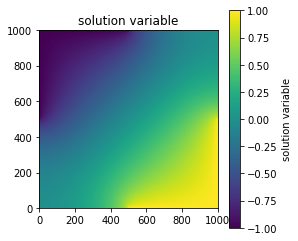

In [8]:
phi.value = 0.5

t1 = time.time()
DiffusionTerm().solve(var=phi, solver=solver)
t2 = time.time()

print("Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((nx/2,), (nx/2)))))
print("Time for solve: {} seconds.".format(t2-t1))

viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='viridis')

In [ ]:
!nvidia-smi

About **4 seconds** on a NVIDIA Tesla P100, slightly faster than the default FiPy solver.

It's easy to test the performance of the other AMGX solver configurations:

In [9]:
with open (os.environ['AMGX_DIR']+'/core/configs/AMG_CLASSICAL_PMIS.json') as f:
    cfg = json.load(f)

cfg['solver']['max_iters'] = 2000
cfg['solver']['print_solve_stats'] = 0

solver = PyAMGXSolver(cfg)

Value of phi at (x, y) = (0.5, 0.5): [0.50000281]
Time for solve: 2.6317391395568848 seconds.


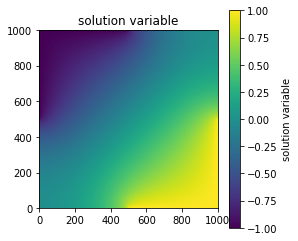

In [10]:
phi.value = 0.5

t1 = time.time()
DiffusionTerm().solve(var=phi, solver=solver)
t2 = time.time()

print("Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((nx/2,), (nx/2)))))
print("Time for solve: {} seconds.".format(t2-t1))

viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='viridis')

## Example 2: Transient diffusion

In the steady problem, data is only transferred from the CPU to GPU once (before the linear solve), and from GPU to CPU once (after the linear solve). In the transient problem, these copies happen every time step, and it will be interesting to see if this impacts performance. For this test, we'll use a smaller mesh:

In [19]:
from fipy import *
nx = 200
ny = nx
dx = 1.
dy = dx
L = dx * nx
mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

phi = CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = 0.5) # `value` specifies the initial values

valueTopLeft = 0
valueBottomRight = 1

X, Y = mesh.faceCenters
facesTopLeft = ((mesh.facesLeft & (Y > L / 2))
                 | (mesh.facesTop & (X < L / 2)))
facesBottomRight = ((mesh.facesRight & (Y < L / 2))
                     | (mesh.facesBottom & (X > L / 2)))

phi.constrain(valueTopLeft, facesTopLeft)
phi.constrain(valueBottomRight, facesBottomRight)

D = 1

### Default FiPy solver

Value of phi at (x, y) = (0.5, 0.5): [0.00106537]
Time for solve: 30.152525663375854 seconds.


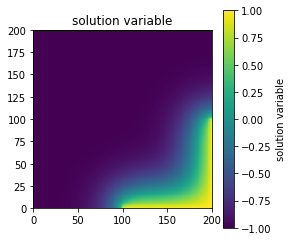

In [20]:
phi.value = 0

eq = TransientTerm() == DiffusionTerm(coeff=D)
timeStepDuration = 10 * 0.9 * dx**2 / (2 * D)
steps = 100

t1 = time.time()
for step in range(steps):
    eq.solve(var=phi,
            dt=timeStepDuration)
t2 = time.time()

print("Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((nx/2,), (nx/2)))))
print("Time for solve: {} seconds.".format(t2-t1))

viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='viridis')

### PyAMGX solver

Value of phi at (x, y) = (0.5, 0.5): [0.00106537]
Time for solve: 9.085797786712646 seconds.


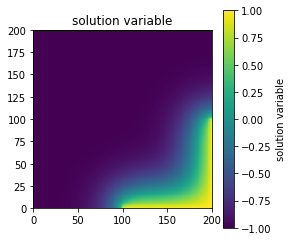

In [21]:
phi.value = 0

eq = TransientTerm() == DiffusionTerm(coeff=D)
timeStepDuration = 10 * 0.9 * dx**2 / (2 * D)
steps = 100

t1 = time.time()
for step in range(steps):
    eq.solve(var=phi,
            dt=timeStepDuration,
            solver=solver)
t2 = time.time()

print("Value of phi at (x, y) = (0.5, 0.5): {}".format(phi(((nx/2,), (nx/2)))))
print("Time for solve: {} seconds.".format(t2-t1))

viewer = Viewer(vars=phi, datamin=0., datamax=1., cmap='viridis')